In [24]:
import torchaudio.functional as F
from pathlib import Path
import torchaudio
import torch
import os

In [25]:
Setting={
    "sample_sound_path" : '/content/sample_sound.wav',
}
class CFG:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    core   = os.cpu_count()
    epoch  = 100

    sr=16000
    n_fft=1024
    hop_length=512
    n_mels=48
    num_output=50

In [26]:
converter1 = torchaudio.transforms.MelSpectrogram(sample_rate=CFG.sr, n_fft=CFG.n_fft, hop_length=CFG.hop_length, n_mels=CFG.n_mels)
converter2 = torchaudio.transforms.AmplitudeToDB()

waveform, sample_rate = torchaudio.load(Setting['sample_sound_path'])
audio_sample = F.resample(waveform[0], sample_rate, 16000, lowpass_filter_width=6)
audio_sample = audio_sample.unsqueeze(0)
feature = converter2(converter1(audio_sample))
feature.shape

torch.Size([1, 48, 911])

In [29]:
def get_resampled_mono_audio_from_file(audio_file_path, target_sr):
  y, sr = torchaudio.load(audio_file_path)
  if y.shape[0] > 1:
    y = torch.sum(y, dim=0) / y.shape[0]

  return y

def slice_audio(audio_sample, sr, start_sec, end_sec):
    trimmed_audio = audio_sample[0][sr*start_sec : sr*end_sec]
    print(trimmed_audio.shape)
    print(int(sr*(end_sec-start_sec)))

    return trimmed_audio

In [30]:
y = get_resampled_mono_audio_from_file(Setting['sample_sound_path'], CFG.sr)
sliced_y = slice_audio(y, CFG.sr, 5, 15)
ipd.display(ipd.Audio(sliced_y, rate=CFG.sr))

torch.Size([160000])
160000


# 이제 증강을 해봅시다!

In [31]:
from specaugment import SpecAugment
import IPython.display as ipd

In [32]:
%time
augmentor = SpecAugment('LB')
augmented_data = augmentor.augment(feature)
print(augmented_data.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 16 µs
torch.Size([1, 48, 911])


In [36]:
import matplotlib.pyplot as plt
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    axs.set_title(title or "Spectrogram")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

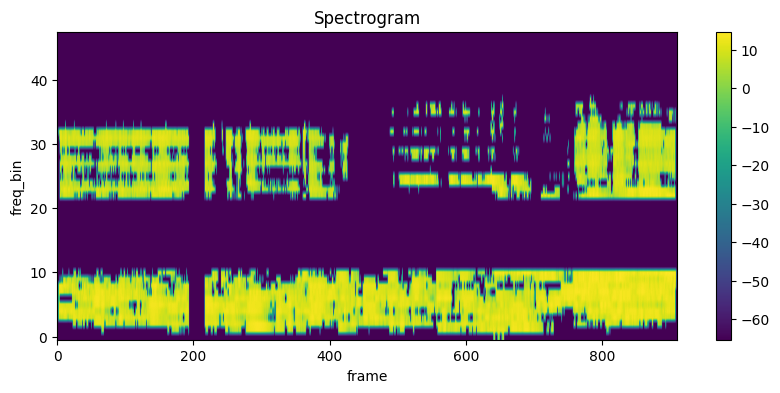

In [38]:
plot_spectrogram(augmented_data.squeeze())